In [ ]:
###### import cPickle, pupil
from pylab import *
import seaborn as sns
import patsy_transforms as pt
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set_style('ticks')
data = cPickle.load(open('s02.pickle'))
events, messages = data['events'], data['messages']
events = events.reset_index()
del events['level_0']
del events['level_1']
events.rename(columns={'level_2':'sample_time'}, inplace=True)
events['sample_time'] = events.sample_time.astype(int)
events['subject'] = 's03'
events.set_index(['session', 'block', 'subject', 'sample_time'], inplace=True)

messages['subject'] = 's03'
messages = messages.reset_index()
del messages['level_0']
del messages['level_1']
del messages['level_2']
messages.set_index(['session', 'block', 'subject', 'trial'], inplace=True)    
messages.feedback[messages.feedback==0] = -1
events.sortlevel(level='subject', inplace=True, axis=1)
messages.sortlevel(level='subject', inplace=True, axis=1)

In [2]:
def plot_fft(data, fs, **kwargs):
    window = 2**floor(log2(len(data)))
    f2 = fft(data[0:window])/float(window)
    freq = fftfreq(f2.shape[-1], 1/100.)
    plot(freq, abs(f2), **kwargs)
    #xticks(log(linspace(0, 1, 11)), linspace(0, 1, 11))

/Users/nwilming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


(0, 0.5)

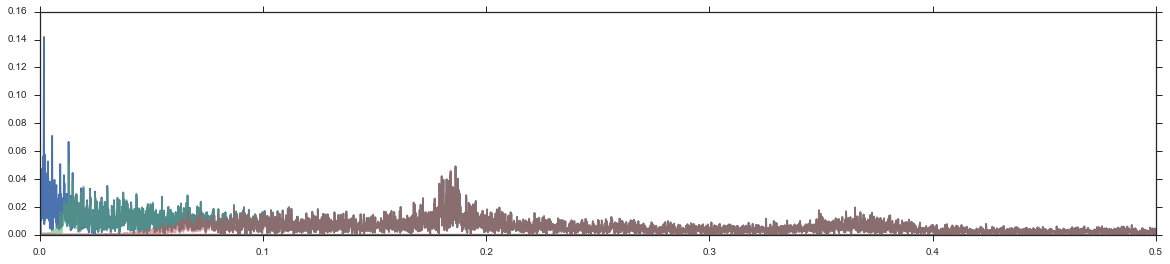

In [3]:
figure(figsize=(20, 4))
plot_fft(events.pa.values, 100.)
low, pa, above = pupil.filter_pupil(events.pa, 100, highcut=10, lowcut=.01)
plot_fft(pa, 100., alpha=0.5)
low, pa, above = pupil.filter_pupil(events.pa, 100, highcut=10, lowcut=0.35*1/(5.5))
plot_fft(pa, 100., alpha=0.5)
xlim([0, .5])

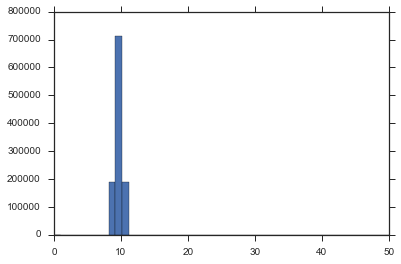

In [4]:
_=hist(diff(events.reset_index().sample_time), linspace(0, 50, 50))

In [5]:
events, messages = pupil.prepare_glm_regressors(events, messages)
e3 = events.loc[(3,slice(None), slice(None))]
m3 = messages.loc[(3,slice(None), slice(None))]

[u'session', u'block', u'subject', u'trial']
[u'session', u'block', u'subject', u'sample_time']


In [6]:
e3['decend'] = e3.decision>0

/Users/nwilming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [7]:
import pupil
yI, ydtI, ydnI = pupil.IRF_pupil()
IRFS = [yI/yI.std(), ydnI/ydnI.std(), ydtI/ydtI.std()]
e3['decend'] = e3.decision>0

/Users/nwilming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
model = '''
pafilt ~        
     pt.MF(ref, func=IRFS) +  
     pt.MF(contrast, func=IRFS) +
     pt.MF(pt.Z(pt.dt(contrast)), func=IRFS) +
     
     pt.MF(decramp21, IRFS) +
     pt.MF(decramp22, IRFS) +
     pt.MF(decramp23, IRFS) +
     pt.MF(decramp24, IRFS) +

     pt.MF(dec_start, IRFS) +
     pt.MF(decend, IRFS) +     
     
     pt.MF(feedback_offset_pos, IRFS) +
     pt.MF(feedback_offset_neg, IRFS) 
'''

model_em = '''
pafilt ~        
     pt.Z(left_gx) +pt.Z(left_gy) +
     pt.MF(pt.Z(left_gx), IRFS) + 
     pt.MF(pt.Z(left_gy), IRFS) + 
     pt.MF(blink, IRFS) +
     pt.MF(pt.Z(pt.dt(left_gx)), IRFS) + 
     pt.MF(pt.Z(pt.dt(left_gy)), IRFS)
'''

model_cm = '''
pafilt ~        
    pt.Z(left_gx) +pt.Z(left_gy) +
     pt.MF(pt.Z(left_gx), IRFS) + 
     pt.MF(pt.Z(left_gy), IRFS) + 
     pt.MF(blink, IRFS) +
     pt.MF(pt.Z(pt.dt(left_gx)), IRFS) + 
     pt.MF(pt.Z(pt.dt(left_gy)), IRFS) +
     
     pt.MF(ref, func=IRFS) +  
     pt.MF(contrast, func=IRFS) +
     pt.MF(pt.Z(pt.dt(contrast)), func=IRFS) +
     
     pt.MF(decramp21, IRFS) +
     pt.MF(decramp22, IRFS) +
     pt.MF(decramp23, IRFS) +
     pt.MF(decramp24, IRFS) +

     pt.MF(dec_start, IRFS) +
     pt.MF(decend, IRFS) +     
     
     pt.MF(feedback_offset_pos, IRFS) +
     pt.MF(feedback_offset_neg, IRFS) 
'''
_='''

'''

In [9]:
rsq1 = []
rsq2 = []
rsq3 = []
cutoffs = linspace(0.0, 2, 40)
for freq_cutoff in cutoffs:
    low, pa, above = pupil.filter_pupil(e3.pa, 100, highcut=10, lowcut=freq_cutoff)
    e3['pafilt'] = pa
    m, yh, y, X, res = pupil.eval_model(model, e3.reset_index(), summary=False)
    rsq2 += [corrcoef(yh.ravel(), y.ravel())[0,1]]
    m, yh, y, X, res = pupil.eval_model(model_em, e3.reset_index(), summary=False)
    rsq1 += [corrcoef(yh.ravel(), y.ravel())[0,1]]
    m, yh, y, X, res = pupil.eval_model(model_cm, e3.reset_index(), summary=False)
    rsq3 += [corrcoef(yh.ravel(), y.ravel())[0,1]]

/Users/nwilming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
0.35*1/(5.5)

0.06363636363636363

/Users/nwilming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


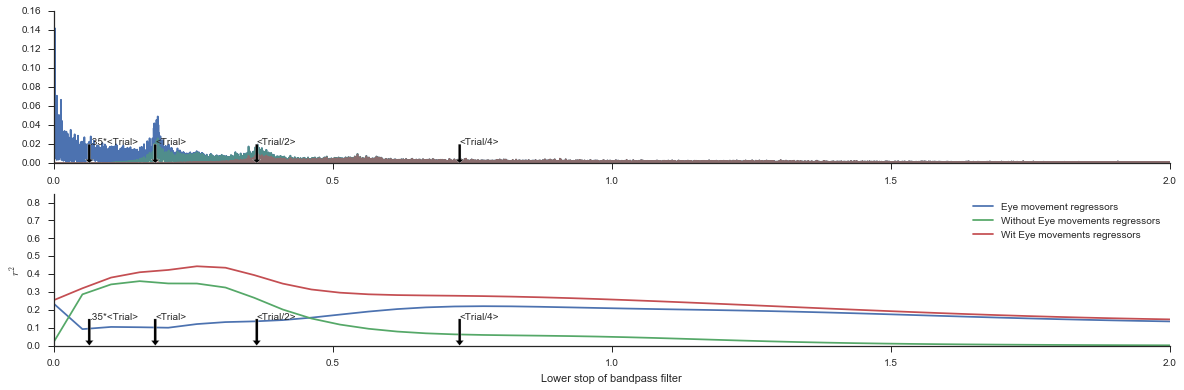

In [23]:
def draw_arrow(x, y, s):
    text(x, y, s)
    yl, yh = ylim()
    arr = Arrow( x, y, 0, -(y-yl), width=0.025, edgecolor='white', facecolor='k', zorder=inf)    
    gca().add_patch(arr)

    
    
figure(figsize=(20, 6))
subplot(2,1,1)
plot_fft(events.pa.values, 100.)
low, pa, above = pupil.filter_pupil(events.pa, 100, highcut=10, lowcut=(1/5.5))
plot_fft(pa, 100., alpha=0.5)
low, pa, above = pupil.filter_pupil(events.pa, 100, highcut=10, lowcut=1/(0.5*5.5))

plot_fft(pa, 100., alpha=0.5)
draw_arrow(.35/(5.5), 0.02, r'.35*<Trial>')
draw_arrow(1/(5.5), 0.02, r'<Trial>')
draw_arrow(1/(0.5*5.5), 0.02, r'<Trial/2>')
draw_arrow(1/(0.25*5.5), 0.02, r'<Trial/4>')

xlim([0, 2])


subplot(2,1,2)
plot(cutoffs, array(rsq1)**2, label='Eye movement regressors')
plot(cutoffs, array(rsq2)**2, label='Without Eye movements regressors')
plot(cutoffs, array(rsq3)**2, label='Wit Eye movements regressors')

ylim([0., 0.85])
xlim([0, 2])
legend()
draw_arrow(1/(5.5), 0.15, r'<Trial>')
draw_arrow(1/(0.5*5.5), 0.15, r'<Trial/2>')
draw_arrow(1/(0.25*5.5), 0.15, r'<Trial/4>')
draw_arrow(.35/(5.5), 0.15, r'.35*<Trial>')


sns.despine()
ylabel(r'$r^2$')
xlabel(r'Lower stop of bandpass filter')

In [12]:
rsq2

[0.14646084594724876,
 0.53584774408848446,
 0.58538116643199456,
 0.60070078620239475,
 0.58992700197973869,
 0.5895640236325117,
 0.5702679414452686,
 0.51780701689725817,
 0.44999490837025363,
 0.39032344499002797,
 0.34396505607223987,
 0.30813250376665108,
 0.28162011529387315,
 0.2636192091409939,
 0.25235812959792425,
 0.24556282356385795,
 0.24108340819085405,
 0.2371852741904894,
 0.23261462635234212,
 0.22656378287471124,
 0.21862049826989727,
 0.20872451058720329,
 0.19711490315363761,
 0.18425324783046632,
 0.17072504991674128,
 0.15713483014446866,
 0.14401343543435247,
 0.13175275247122498,
 0.1205765472883886,
 0.110548321488367,
 0.10160854021086889,
 0.093626505190241738,
 0.086450047521642578,
 0.079940626844896626,
 0.07398968216933173,
 0.068519490076662484,
 0.063475355690933474,
 0.058815695138738661,
 0.054504200828807733,
 0.050505615483904753]

In [13]:
low, pa, above = pupil.filter_pupil(e3.pa, 100, highcut=1, lowcut=0.25)
e3['pafilt'] = pa
m, yh, y, X, res = pupil.eval_model(model, e3.reset_index(), summary=False)
print corrcoef(yh.ravel(), y.ravel())[0,1]**2

0.413329415696


/Users/nwilming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [14]:

s = (1/5.5)
low, pa1, above = pupil.filter_pupil(e3.pa, 100, highcut=s+s/2, lowcut=s-s/2)
low, pa2, above = pupil.filter_pupil(e3.pa, 100, highcut=2*s+s/2, lowcut=s+s/2)
low, pa3, above = pupil.filter_pupil(e3.pa, 100, highcut=2*s+s/2, lowcut=s-s/2)

(-4, 4)

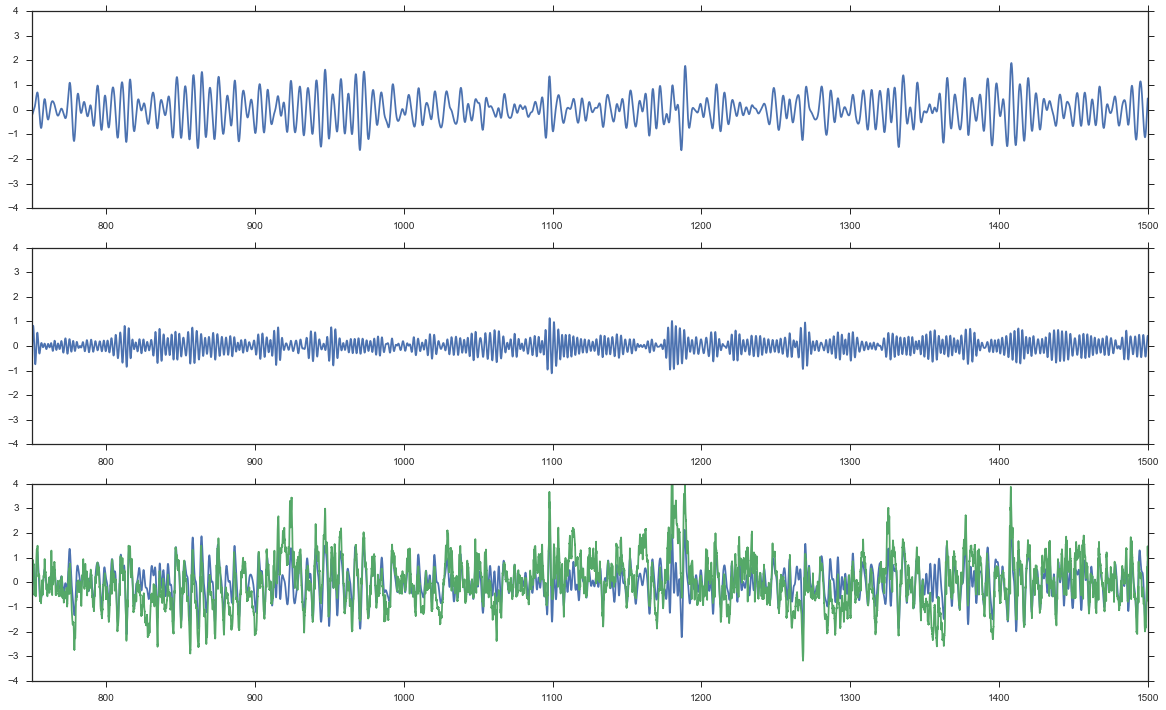

In [15]:
figure(figsize=(20, 12))
xl = [750, 1500]
time = arange(len(pa1))/100.
subplot(3,1,1)
plot(time, pa1)
xlim(xl)
ylim([-4, 4])
subplot(3,1,2)
plot(time, pa2)
#plot(time, pa3)
xlim(xl)
ylim([-4, 4])
subplot(3,1,3)
plot(time, pa2+pa1)
plot(time, e3.pa)
xlim(xl)
ylim([-4, 4])

(-2, 2)

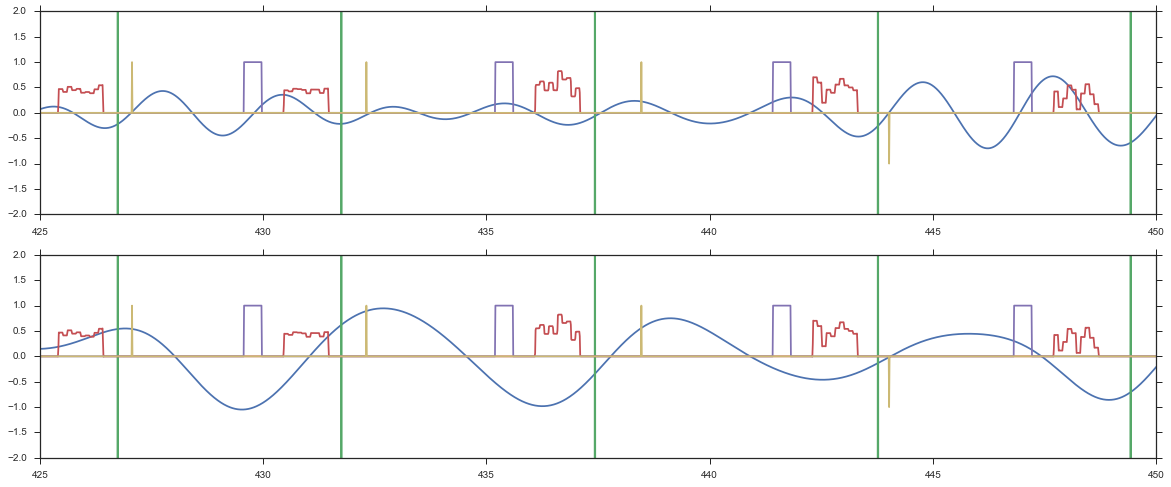

In [16]:
figure(figsize=(20, 8))
xl = [425, 450]
subplot(2,1,1)
time = arange(len(pa1))/100.
plot(time, pa2)
plot(time, e3.decision-10)
plot(time, e3.contrast)
plot(time, e3.ref)
plot(time, e3.feedback)
#plot(time, events.pa)
xlim(xl)
ylim([-2,2])

subplot(2,1,2)
plot(time, pa1)
#plot(time, events.pa)
plot(time, e3.decision-10)
plot(time, e3.contrast)
plot(time, e3.ref)
plot(time, e3.feedback)
xlim(xl)
ylim([-2,2])


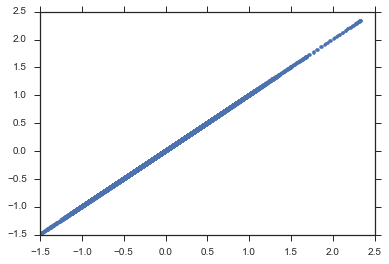

In [17]:
plot(y, pa, '.')

1.41 0.709219858156


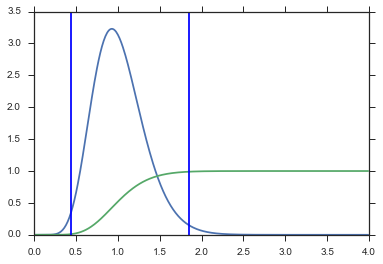

In [18]:
t = arange(len(yI))/100.
FyI = cumsum(yI)/sum(yI)
low =  t[where(FyI>0.01)[0][0]]
high = t[where(FyI<0.99)[0][-1]]
plot(t, yI)
plot(t, cumsum(yI)/sum(yI))
axvline(low)
axvline(high)
dt = high-low
print dt, 1/dt

In [19]:
# What is the maximal rate of change? ca. 7mm/s
# How do we convert this to z-scored pupil values?
